**Note:** This notebook is written in the Julia language, so the cells
  can't be executed in Google Colab. If you want to verify that the
  notebook works, I recommend [JuliaBox](https://juliabox.com/) (which
  is free and requires no installation) or testing locally. The syntax
  is very similar to Python and MATLAB. Note in particular the dot
  syntax used to perform elementwise operations ( `f.(x)` applies `f`
  to all elements of `x` ), that indices start at 1 and that the last
  statement of all functions is returned automatically.

**Extra note:** The creators of Julia recently received the Wilkinson
  Prize for Numerical Software, a prize also awarded to the creator of
  the Triangle mesh generator. Here is a
  [talk](https://www.youtube.com/watch?v=OfMP5PTFQk0&feature=youtu.be)
  from the event.

# **Lab 7: Optimization and learning**
**Anders Ågren Thuné**

# **Abstract**

# **About the code**

In [1]:
"""
DD2363 Methods in Scientific Computing,
KTH Royal Institute of Technology, Stockholm, Sweden.
"""

# Copyright (C) 2019
# Anders Ågren Thuné (athune@kth.se)
# Johan Hoffman (jhoffman@kth.se)

# Code written by Anders Ågren Thuné based on the template by Johan Hoffman.

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

"DD2363 Methods in Scientific Computing,\nKTH Royal Institute of Technology, Stockholm, Sweden.\n"

# **Set up environment**

In [2]:
using LinearAlgebra
using Plots
using Random
using MLDatasets

# **Introduction**

Optimization is the study of finding the optimal value of some domain,
typically the maximum or minimum of some function. This is a field
with a broad range of applications, not least in the rapidly growing
field of machine learning.

In order to find the critical points of a function, the derivative or
multivariate versions thereof are typically powerful tools, as they
indicate the direction to move in the input space to achieve the
largest change in the output, the 'steepest slope' in a sense. Two
methods making use of this fact to perform unconstrained optimization
in $\mathbb{R}^n$ are the gradient descent method and the Newton
method.

A neural network is a mathematical model for function approximation
vaguely inspired by biological neural networks. While research is
advancing rapidly, neural networks first appeared as early as during
the 60s. The simplest version of a neural network is called a
feedforward neural network, in which output is simply channeled
forward through the network with no feedback loops or memory.

The gradient descent method is typically used when training artificial
neural networks, as it is a relatively cheap way to find minima of a
cost function, especially when a stochastic version is used.

[Hoffman 2019, Chapter 19, Nielsen 2015, Chapter 1]

This report presents how the gradient descent and Newton methods were
implemented in the Julia language. In addition, a simple feedforward
neural network was implemented and trained using the backpropagation
algorithm.

# **Methods**

### **Gradient descent and Newton's method**

Gradient descent utilizes the fact that the gradient indicates the
direction of steepest ascent to step through the input space to search
for an optimum. Newton's method is similar, but while gradient descent
uses a step size $\alpha^{(k)}$ determined somewhat heuristically,
Newton's method multiplies the gradient with the inverse Hessian to
determine the update (analogous to how Newton's method for nonlinear
systems of equations uses the Jacobian), resulting in a somewhat more
expensive method, but with a higher order of convergence. Also, as
multiplying with the Hessian might result in either a negative or
positive update depending on the function, Newton's method will find a
_stationary point_, as opposed to a minimum specifically.

Gradient descent: $$x^{(k+1)} = x^{(k)} - \alpha^{(k)}\nabla
f(x^{(k)}),$$ for $\alpha^{(k)}$ so that $f(x^{(k+1)}) \leq \beta
f(x^{(k)})$, where $\beta < 1$ is a fixed parameter.

Newton's method: $$x^{(k+1)} = x^{(k)} - (Hf(x^{(k)}))^{-1}\nabla
f(x^{(k)}) $$

In order to obtain the $\alpha$-value for the gradient descent method,
I use a heuristic approach, starting with an arbitrarily chosen
$\alpha^{(0)}$. For each step, if the constraint $f(x^{(k+1)}) \leq
\beta f(x^{(k)})$ is not fulfilled, I nudge $\alpha^{(k)}$ and adjust
$x^{(k+1)}$. The sign of the nudge is set to the sign of $(\nabla
f(x^{(k)}), \nabla f(x^{(k+1)}))$, as this indicates whether or not
$\nabla f (x^{(k)})$ is aligned with $\nabla f (x^{(k+1)})$, or in
other words, roughly, whether the constraint is not fulfilled because we
overshot or undershot the step length.

In [3]:
"""
Calculate J(f)(p), modifying `jac` in place. Reused from lab 5.
"""
function filljacobian!(jac, f, p, h = 1e-5)
    p1 = p
    p2 = copy(p1)
    for i in 1:length(p)
        p1[i] += h
        p2[i] -= h

        jac[:,i] .= (f(p1) - f(p2)) / 2h

        p1[i] -= h
        p2[i] += h
    end
end

"""
Calculate ∇(f)(x), modifying `v` in place.
"""
fillgradient!(v, f, p, h = 1e-5) = filljacobian!(v', f, p, h)

"""
Use gradient descent to find x* such that ||∇(f)(x*)|| < TOL
Use α = `α` initially, refining it if f(x^(k+1)) > βf(x^(k))
"""
function gradient_descent(f, β, x⁽⁰⁾, α = 0.1, TOL = 1e-6; maxiter::Int = 2000)
    x = copy(x⁽⁰⁾)

    ∇f = zeros(length(x))
    next_∇f = zeros(length(x))

    fillgradient!(∇f, f, x)
    prev_f = f(x)

    i = 1
    while norm(∇f) >= TOL && i < maxiter
        @. x -= α * ∇f #@. means "apply every function pointwise"
        fillgradient!(next_∇f, f, x)
        while (new_f = f(x)) > β*prev_f
            # nudge alpha and adjust x if we over/undershoot
            nudge = 0.2*sign(dot(∇f, next_∇f))
            @. x -= nudge * α * ∇f
            α *= (1.0 + nudge)
            fillgradient!(next_∇f, f, x)
        end
        ∇f .= next_∇f
        prev_f = new_f
        i += 1
    end
    x
end

"""
Use Newton's method to find x* such that ||∇(f)(x*)|| < TOL
"""
function newton_optimization(f, H, x⁽⁰⁾, TOL = 1e-6; maxiter::Int = 2000)
    x = copy(x⁽⁰⁾)

    ∇f = zeros(length(x))
    fillgradient!(∇f, f, x)

    i = 1
    while norm(∇f) >= TOL && i < maxiter
        x .-= H(x) \ ∇f
        fillgradient!(∇f, f, x)
        i += 1
    end
    x
end

newton_optimization

### **Neural networks and back propagation**

A feedforward neural network consists of layers of neurons, each of
which accepts weighted input from the previous layer and uses an
activation function to produce an output which is in turn fed to the
following layer. Put mathematically: $$y'_i = a(\sum_j w_jy_j +
b_i),$$ where $y_j$ are the output values of the neurons in the layer
previous to $y'_i$, $w_j$ are the corresponding weights, $b_i$ is a
bias determining how likely $y'_i$ is to activate and $a$ is an
activation function, typically outputting a value in the range
$[0,1]$. Expressed in terms of matrices, we have: $$y' = a(Wy +
b)$$ A typical activation function is the sigmoid function $\sigma(x)
= \frac{1}{1+e^{-x}}$, as its output is in the desired range and its
derivative is convenient to work with.

In order to make the network approximate the desired function, the
free parameters $w$ and $b$ need to be selected to minimize the
difference between the output of the network and the objective
function, thus resulting in an optimization problem. If the error in
the output is given by $E(y)$, with $y$ the output of the network for
a given input, we can use gradient descent to update the weights and
biases of the network to minimize the error. However, this requires
the partial derivatives $\frac{\delta E}{\delta w}$ and $\frac{\delta
E}{\delta b}$ for all weights and biases in the network.

Backward propagation is a recursive algorithm for computing the
required partial derivatives. Without delving into the details, the
partial derivative $\frac{\delta E}{\delta w_{kj}}$ for a weight
between nodes $k$ and $j$ in two consecutive layers is given by
$\frac{\delta E}{\delta y_j}\frac{\delta y_j}{\delta x_j}\frac{\delta
x_j}{\delta w_{kj}}$, where $x_j$ is the sum of the weighted inputs to
node $j$ before the activation function, and $\frac{\delta E}{\delta
y_j}$ given recursively by $\sum_i \frac{\delta E}{\delta y'_i}\frac{\delta
y'_i}{\delta x'_i}\frac{\delta x'_i}{\delta y_j}$. Similarly,
$\frac{\delta E}{\delta b_{jk}} = \frac{\delta E}{\delta
y_j}\frac{\delta y_j}{\delta x_j} \frac{\delta x_j}{\delta
w_{kj}}$. Abstractly, the backward propagation algorithm involves
three steps: a forward propagating step calculating the output values
for each node, a backward propagating step calculating the partial
derivatives $\frac{\delta E}{\delta y}$ for each node, and a final
local step to update each weight and bias.

In [141]:
σ(x) = 1.0/(1.0+exp(-x))
error_derivative(y, t) = -(t-y)

struct FeedforwardNetwork
    sizes::Array{Int64}
    weights::Array{Array{Float64,2}}
    biases::Array{Array{Float64}} 
end

function FeedforwardNetwork(sizes)
    #initialiaze weights and biases randomly
    weights = [randn(j,i) for (i,j) in zip(sizes[1:end-1],sizes[2:end])]
    biases = [randn(i) for i in sizes[2:end]] #input layer has no bias
    FeedforwardNetwork(sizes, weights, biases)
end

"""
Compute the output of network `n` for input `x`.
"""
function feedforward(n::FeedforwardNetwork, x)
    maxsize = max(n.sizes...)
    output = zeros(maxsize)
    output[1:n.sizes[1]] .= x

    for i in 1:length(n.sizes)-1
        W = n.weights[i]; b = n.biases[i]
        output[1:n.sizes[i+1]] .= σ.(W*output[1:n.sizes[i]] .+ b)
    end

    output[1:n.sizes[end]]
end

struct BackpropStorage #preallocated storage for backpropagation
     ∇w::Array{Array{Float64,2}}
     ∇b::Array{Array{Float64}}
     outputs::Array{Array{Float64}}
     deltas::Array{Array{Float64}}
end

function BackpropStorage(n::FeedforwardNetwork)
    ∇w = [zeros(j, i) for (i, j) in zip(n.sizes[1:end-1], n.sizes[2:end])]
    ∇b = [zeros(s) for s in n.sizes[2:end]]
    deltas = [zeros(s) for s in n.sizes[2:end]]
    outputs = [zeros(s) for s in n.sizes]
    BackpropStorage(∇w, ∇b, outputs, deltas)
end

"""
Train the network `n` for `iterations` iterations using single sample
stochastic gradient descent. `data` and `targets` should be matrices
where each column corresponds to a data sample.
"""
function stochastic_gradient_descent(n::FeedforwardNetwork, data, targets, iterations, α)
    b = BackpropStorage(n)
    for i in 1:iterations
        for i in randperm(size(data,2))
            backprop!(n, b, data[:,i], targets[:,i], α)
        end
    end
end

"""
Use backpropagation to compute the gradient ∇E and update the weights
and biases of the network `n`.
"""
function backprop!(n::FeedforwardNetwork, b::BackpropStorage, sample, target, α)
    nlayers = length(n.sizes)
    #perform forward propagation step
    b.outputs[1] .= sample
    for i in 1:nlayers-1
        W = n.weights[i]; bias = n.biases[i]
        b.outputs[i+1] .= σ.(W*b.outputs[i] .+ bias)
    end

    #compute final layer derivatives
    @. b.deltas[end] = error_derivative(b.outputs[end], target) * b.outputs[end] * (1.0 - b.outputs[end])
    b.∇b[end] .= b.deltas[end]
    for row in 1:n.sizes[end]
        @. b.∇w[end][row,:] = b.deltas[end][row]*b.outputs[end-1]
    end

    # backpropagate error
    for layer in nlayers-1:-1:2
        layer_wb = layer-1 # biases and weights are 1 shorter
        for row in 1:n.sizes[layer]
            b.deltas[layer_wb][row] = dot(n.weights[layer_wb+1][:,row], b.deltas[layer_wb + 1])
        end
        @. b.deltas[layer_wb] *= b.outputs[layer]*(1.0 - b.outputs[layer])

        b.∇b[layer_wb] .= b.deltas[layer_wb]
        for row in 1:n.sizes[layer]
            @. b.∇w[layer_wb][row,:] = b.deltas[layer_wb][row]*b.outputs[layer-1]
        end
    end

    #update weights and biases
    for i in 1:nlayers-1
        @. n.weights[i] -= α * b.∇w[i]
        @. n.biases[i] -= α * b.∇b[i]
    end
end

backprop!

# **Results**

This section presents verification and visualization of the implemented methods.

### **Gradient descent and Newton's method**

To test gradient descent and Newton's method, I use the function
$f(x, y) = x^2 - sin(x) + cos(y)$ with Hessian $Hf(x) = \matrix{2 + sin(x) & 0
\\ 0 & -cos(y)}$. For this function, i use two values for $x^{(0)}$,
$(-2, 0.5)$ and $(-2, 2)$, where the first point is closest to a
saddle point and the second closest to a minimum.

In [5]:
sinusoidal(x) = x[1]^2 - sin(x[1])+cos(x[2])
sinusoidalHessian(x) = [2 + sin(x[1]) 0; 0 -cos(x[2])]

xgrid = range(-3.5,stop=3.5,length=100)

-3.5:0.0707070707070707:3.5

#### **Saddle point**

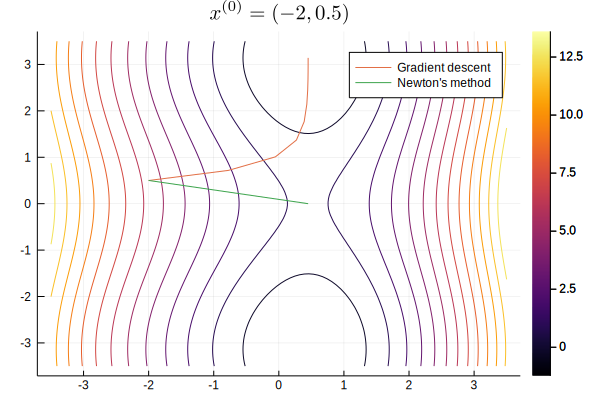

In [6]:
x⁽⁰⁾ = [-2., 0.5]
xs_gradient_descent = [x⁽⁰⁾]
x = gradient_descent(sinusoidal, 0.8, xs_gradient_descent[end], maxiter = 5)
while x != xs_gradient_descent[end]
    push!(xs_gradient_descent, x)
    x = gradient_descent(sinusoidal, 0.8, x, maxiter = 5)
end
xs_newton = [x⁽⁰⁾]
x = newton_optimization(sinusoidal, sinusoidalHessian, xs_newton[end], maxiter = 5)
while x != xs_newton[end]
    push!(xs_newton, x)
    x = newton_optimization(sinusoidal, sinusoidalHessian, x, maxiter = 15)
end

xs_gradient_descent = hcat(xs_gradient_descent...)'
xs_newton = hcat(xs_newton...)'

contour(xgrid, xgrid, (x,y) -> sinusoidal([x,y]), title = "\$x^{(0)} =
(-2, 0.5)\$")
plot!(xs_gradient_descent[:,1], xs_gradient_descent[:,2], label = "Gradient descent")
plot!(xs_newton[:,1], xs_newton[:,2], label = "Newton's method")

We see that while the gradient descent function finds a minimum,
Newton's method goes for the saddle point, which is closer.

#### **Minimum**

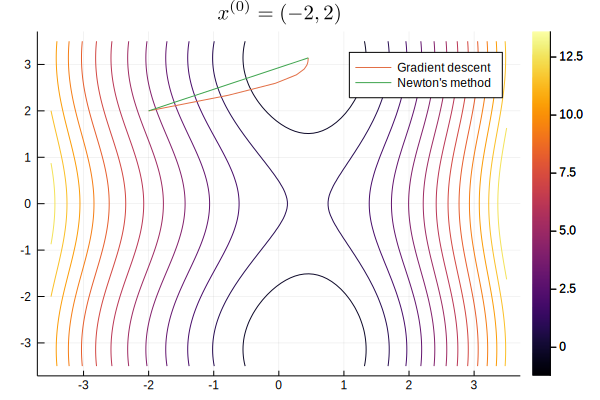

In [7]:
x⁽⁰⁾ = [-2., 2]
xs_gradient_descent = [x⁽⁰⁾]
x = gradient_descent(sinusoidal, 0.8, xs_gradient_descent[end], maxiter = 5)
while x != xs_gradient_descent[end]
    push!(xs_gradient_descent, x)
    x = gradient_descent(sinusoidal, 0.8, x, maxiter = 5)
end
xs_newton = [x⁽⁰⁾]
x = newton_optimization(sinusoidal, sinusoidalHessian, xs_newton[end], maxiter = 5)
while x != xs_newton[end]
    push!(xs_newton, x)
    x = newton_optimization(sinusoidal, sinusoidalHessian, x, maxiter = 15)
end

xs_gradient_descent = hcat(xs_gradient_descent...)'
xs_newton = hcat(xs_newton...)'

contour(xgrid, xgrid, (x,y) -> sinusoidal([x,y]), title =
"\$x^{(0)}=(-2, 2)\$")
plot!(xs_gradient_descent[:,1], xs_gradient_descent[:,2], label = "Gradient descent")
plot!(xs_newton[:,1], xs_newton[:,2], label = "Newton's method")

Here, both methods go for the same critical point, $(~0.450184, \pi)$,
and we clearly see that Newton's method takes the straighter path.

#### **Convergence**

In [8]:
println("Steps required for gradient descent: $(size(xs_gradient_descent, 1))")
println("Steps required for newton: $(size(xs_newton, 1))")

Steps required for gradient descent: 35
Steps required for newton: 3


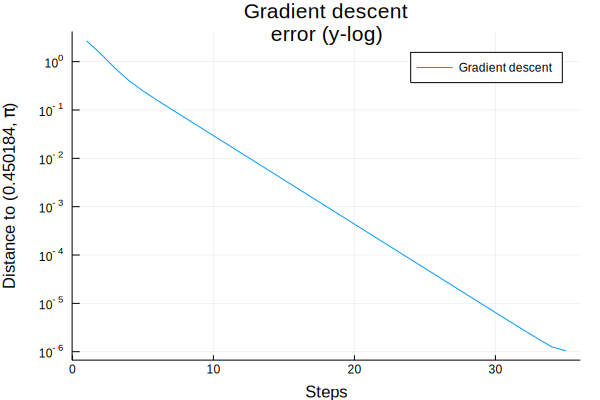

In [9]:
plot([norm(xs_gradient_descent[i,:].-[0.450184, π])
for i in 1:size(xs_gradient_descent, 1)],
yscale = :log10, label = "Gradient descent", title = "Gradient descent
error (y-log)", xlabel = "Steps", ylabel = "Distance to (0.450184, \\pi)")

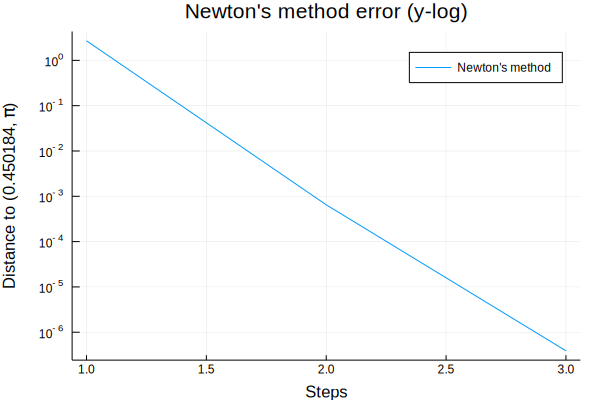

In [10]:
plot(1:size(xs_newton, 1), [norm(xs_newton[i,:].-[0.450184, π]) for i in 1:size(xs_newton, 1)], yscale = :log10,
label = "Newton's method", title = "Newton's method error (y-log)",
xlabel = "Steps", ylabel = "Distance to (0.450184, \\pi)")

### **Neural networks and back propagation**

In order to test the neural network code, I use the
[FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) data
set, verifying that the network is able to learn using the data.

In [163]:
traindata = Float64.(MNIST.convert2features(MNIST.traintensor()))
trainlabels = MNIST.trainlabels()

(nrdims, nrpoints) = size(traindata)
traintargets = zeros(10, nrpoints)
for i in 1:length(trainlabels)
    traintargets[trainlabels[i]+1, i] = 1
end

testdata = Float64.(MNIST.convert2features(MNIST.testtensor()))
testlabels = MNIST.testlabels();
nrtestpoints = size(testdata, 2)

function evaluate_net(n::FeedforwardNetwork)
     correct = sum((findmax(feedforward(n, testdata[:,i]))[2]-1) == testlabels[i] for i in 1:nrtestpoints)
     println("Accuracy: $correct / $nrtestpoints")
end

evaluate_net (generic function with 1 method)

In [164]:
ffnet = FeedforwardNetwork([nrdims, 16, 10])

FeedforwardNetwork([784, 16, 10], Array{Float64,2}[[0.59475 -0.0565387 … -1.2704 0.55486; -0.0824654 -0.351712 … -0.30587 -0.0806427; … ; 1.43514 -0.341432 … 1.59455 0.0161595; 0.537445 0.183777 … 1.39576 -1.3087], [0.365739 1.3875 … -1.99664 -2.18096; 1.13683 -1.07935 … -0.948022 -0.0450257; … ; 0.350789 0.405323 … 0.239551 0.373013; 0.459674 -0.713088 … -0.160606 0.370935]], Array{Float64,N} where N[[2.04058, 1.63217, 1.28409, 0.170149, -0.493538, 0.494444, -0.212782, -1.13923, 0.758898, 0.498692, -0.684472, 1.31882, 0.625236, 1.21759, 0.106608, -0.682535], [1.31059, -0.859345, -0.554729, 0.0866632, 1.15908, -0.40317, 0.543667, -0.504674, 0.0482906, -1.43113]])

In [170]:
stochastic_gradient_descent(ffnet, traindata, traintargets, 1, 1.0)
evaluate_net(ffnet)

Accuracy: 8962 / 10000


In [107]:
norm(traindata[:,1])

9.557696263345086

In [125]:
sum(ffnet.biases[2] .!= 0)

0

In [161]:
findmax(feedforward(ffnet, traindata[:, 300])

2

In [41]:
function ffs(n::FeedforwardNetwork, a)
    for (b, w) in zip(n.biases, n.weights)
        a = σ.(w*a+b)
    end
    a
end

ffs (generic function with 1 method)

In [272]:
786*16

12576

# **Discussion**

Both optimization methods worked as expected. For the example
function, the Hessian was easily obtained by hand and Newton's method
clearly converged faster than the gradient descent method. However,
this could partially be because of an inappropriate choice of initial
$\alpha$-value for the gradient descent method. While testing the
gradient descent method, it was also important not to set $\beta$ too
low, as the function would have trouble terminating. This is
understandable, as it may not always be possible to achieve the
desired decrease in the objective function, especially when close to a
minimum. In conclusion, while the gradient descent method does not
require the Hessian, it seems to be more sensitive to parameter
choices than Newton's method.

# **References**

- Hoffman, Johan. 2019. *Introduction to Scientific Computing*
- Nielsen, Michael A. 2015. *Neural Networks and Deep Learning*. Determination Press.